In [1]:
import torch
import logging
from os import listdir
from os.path import splitext
from pathlib import Path

import numpy as np

from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F

dir_img = Path('/home/igor/ml/solaris_test/tiling/3_3/') # Path('./data/imgs/')
dir_mask = Path('/home/igor/ml/solaris_test/tiling/maskRGB/') # Path('./data/masks/')
dir_checkpoint = Path('./checkpoints/')

ModuleNotFoundError: No module named 'torch'

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from data_loading import BasicDataset, BasicDatasetRGB, CarvanaDataset
from dice_score import dice_loss
#from evaluate import evaluate
#from unet import UNet

In [65]:
img_scale = 1.0
val_percent = 0.2
batch_size = 2

In [62]:


dataset = BasicDatasetRGB(dir_img, dir_mask, img_scale)

In [64]:
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))


In [66]:
loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [11]:
mask_folder = '/home/igor/ml/solaris_test/tiling/maskRGB/'
mask_path = '/home/igor/ml/solaris_test/tiling/maskRGB/3_3_1.png'

colors = np.array([[0,0,0],[255,0,0],[0,255,0],[0,0,255]])
mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

def mask_to_class(self, mask):

        #target = torch.from_numpy(mask)

        target = mask

        h,w = target.shape[0],target.shape[1]

        masks = torch.empty(h, w, dtype=torch.long)

        #colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()

        #print("colors: ", colors)

        #print("len(colors): " + str(len(colors)))

        target = target.permute(2, 0, 1).contiguous()

        mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

        #print("mapping: " + str(mapping))

        for k in mapping:

            #print("k: " + str(k))

            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))

            validx = (idx.sum(0) == 3) 

            masks[validx] = torch.tensor(mapping[k], dtype=torch.long)
        
        #print(masks)

        return masks

mask=torch.as_tensor( np.asarray(Image.open(mask_path).copy()))
mask1=mask_to_class(None, mask)
print(mask.shape)
print(mask1.shape)




torch.Size([512, 512, 3])
torch.Size([512, 512])


In [12]:
img = Image.fromarray(mask.numpy())

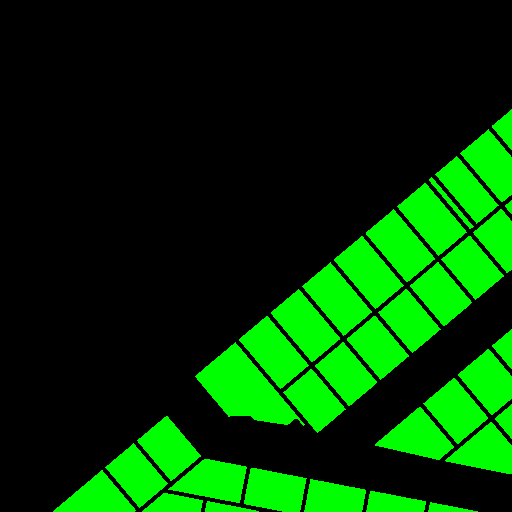

In [13]:
img

In [14]:
onehot = F.one_hot(mask1, )

onehot.shape

torch.Size([512, 512, 3])

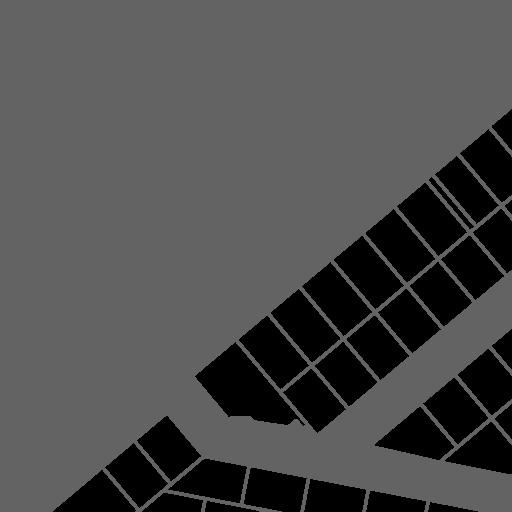

In [38]:
#onehot[400,450]

img_mask = Image.fromarray( 25500 * np.array(onehot[:,:,0].numpy(),dtype=np.uint8))
img_mask


In [16]:
onehot1 = np.array( onehot.numpy(),dtype=np.uint8)


In [17]:
img2 = Image.fromarray(onehot1.astype(np.uint8) * 255)

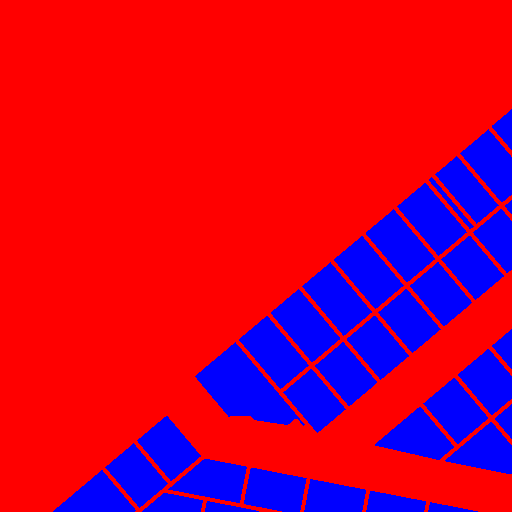

In [24]:
img2

In [23]:
torch.as_tensor( onehot1).long().dtype

torch.int64

In [51]:
torch.unique(mask.view(-1,mask.size(2)),dim=0).numpy()

array([[  0,   0,   0],
       [  0, 255,   0]], dtype=uint8)

In [53]:
mask.view(-1,mask.size(2)).shape

torch.Size([262144, 3])

In [55]:
mask.numpy().size

786432

In [56]:
masks_true = np.array([mask])
masks_pred = np.array([mask])

/tmp/ipykernel_19953/1822912054.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  masks_true = np.array([mask])


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
loss = nn.CrossEntropyLoss()(masks_pred, true_masks) #\
         + dice_loss(F.softmax(masks_pred, dim=1).float(),
                     F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                    multiclass=True)